In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("twf.csv")
df.head()

,Date,Time,Open,High,Low,Close,TotalVolume
0,2010/1/4,08:46:00,8203.0,8208.0,8184.0,8187.0,1108
1,2010/1/4,08:47:00,8187.0,8195.0,8186.0,8193.0,429
2,2010/1/4,08:48:00,8194.0,8201.0,8193.0,8200.0,419
3,2010/1/4,08:49:00,8200.0,8203.0,8198.0,8200.0,295
4,2010/1/4,08:50:00,8200.0,8201.0,8195.0,8197.0,187


In [10]:
df.index = pd.to_datetime(df["Date"]+ ' ' + df["Time"])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

In [11]:
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2010-01-04 08:46:00,8203.0,8208.0,8184.0,8187.0,1108,8
2010-01-04 08:47:00,8187.0,8195.0,8186.0,8193.0,429,8
2010-01-04 08:48:00,8194.0,8201.0,8193.0,8200.0,419,8
2010-01-04 08:49:00,8200.0,8203.0,8198.0,8200.0,295,8
2010-01-04 08:50:00,8200.0,8201.0,8195.0,8197.0,187,8
...,...,...,...,...,...,...
2019-12-31 23:55:00,11996.0,11996.0,11995.0,11995.0,46,23
2019-12-31 23:56:00,11996.0,11998.0,11995.0,11995.0,27,23
2019-12-31 23:57:00,11996.0,11996.0,11995.0,11995.0,19,23
2019-12-31 23:58:00,11996.0,11998.0,11996.0,11998.0,16,23


Text(0.5, 1.0, 'Volume History')

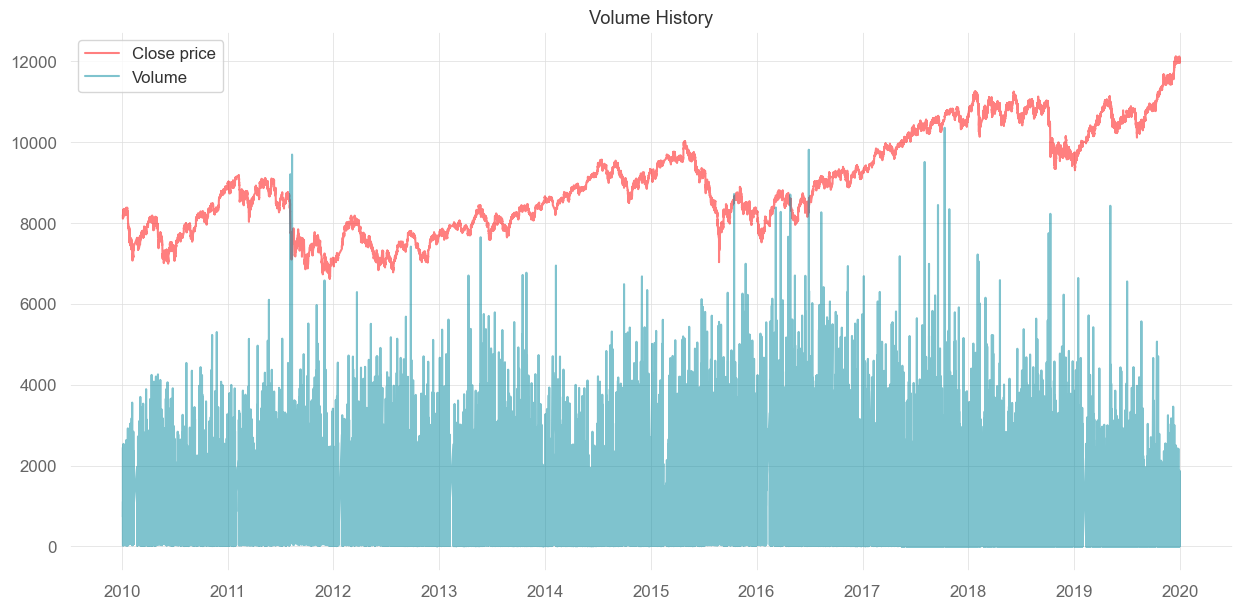

In [13]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History')

### 抓資料並切割樣本

In [173]:
#split to in and out sample
price_all = df[['Open', 'High', 'Low', 'Close']]
price_is = price_all['2020-01-01':'2022-08-31'] # in sample data
price_os = price_all['2022-09-01':'2023-08-15'] # out sample data
print(price_all)
print(price_is)
print(price_os)

                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00:15:00   7176.22   7179.41   7170.69   7172.36
2020-01-01 00:30:00   7172.79   7179.45   7170.61   7174.83
2020-01-01 00:45:00   7174.51   7179.36   7170.15   7171.55
2020-01-01 01:00:00   7171.43   7188.77   7171.10   7186.60
...                       ...       ...       ...       ...
2023-08-14 23:00:00  29426.50  29426.60  29413.40  29416.00
2023-08-14 23:15:00  29416.00  29419.50  29413.90  29418.80
2023-08-14 23:30:00  29418.80  29432.40  29414.30  29428.00
2023-08-14 23:45:00  29428.00  29430.50  29416.90  29419.50
2023-08-15 00:00:00  29419.50  29433.00  29406.50  29429.20

[126913 rows x 4 columns]
                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00

### 定義策略

In [101]:
#double rsi as signal and filter
def rsi_long(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossover & (rsi_filter > 70), 1, 0)
    signal = np.where(rsi_crossunder, -1, signal)

    return signal

MyInd = vbt.IndicatorFactory(
    class_name = 'rsi_long',
    short_name = 'long',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_long, keep_pd=True)

### 參數優化

In [218]:
#run strategy and do parameter optimization on in sample data

win = np.arange(20, 50)
signal = MyInd.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio = vbt.Portfolio.from_signals(
    price_is['Close'],
    #price_is['Close'].shift(-1), 
    entries, 
    exits,
    freq = '15m', 
    direction = 'longonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

print(portfolio.total_return().sort_values())
print(portfolio.sharpe_ratio().sort_values())

long_rsi_window  long_filter_window
20               20                   -0.592385
21               21                   -0.528170
22               41                   -0.449519
                 42                   -0.423551
                 43                   -0.394123
                                         ...   
49               21                    4.982664
32               34                    5.034642
49               33                    5.117464
                 20                    5.157155
                 38                    5.674729
Name: total_return, Length: 900, dtype: float64
long_rsi_window  long_filter_window
22               41                   -0.805691
                 42                   -0.721886
                 43                   -0.712548
21               48                   -0.612060
                 44                   -0.562227
                                         ...   
32               34                    1.777865
33              

In [220]:
pf = pd.concat([portfolio.total_return(),  portfolio.sharpe_ratio()], axis=1)

In [9]:
# 畫出參數高原
import plotly.graph_objects as go

x = pf.loc[pf['total_return'] > 0].index.get_level_values(0)
y = pf.loc[pf['total_return'] > 0].index.get_level_values(1)
z = pf.loc[pf['total_return'] > 0]['total_return']
data = (pf.loc[pf['total_return'] > 0]['sharpe_ratio'])
scatter_data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=data,  # 将第四维数据用颜色表示
        colorscale='Viridis',
        colorbar=dict(title='Sharpe')  # 添加颜色条
    )
)

# 创建图布局
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='rsi_window'),
        yaxis=dict(title='filter_window'),
        zaxis=dict(title='return')
    )
)

# 创建图像的 Figure 对象并绘制图像
fig = go.Figure(data=[scatter_data], layout=layout)
fig.show()
fig.write_html(file = '3d_plot.html' , auto_open  = True)#圖片儲存並自動展

In [221]:
#select strategies with best sharpe ratio
idx_best_10_sharpe = pf.loc[np.logical_and(pf.index.get_level_values(0) > 25, pf.index.get_level_values(0) < pf.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:10].to_list()
idx_best_10_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:10].to_list()
idx_best_5_sharpe = pf.loc[np.logical_and(pf.index.get_level_values(0) > 25, pf.index.get_level_values(0) < pf.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
#idx_best_5_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
idx_best_5_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:5].to_list()
print("best 10 sharpe: " + str(idx_best_10_sharpe))
print("best 10 return: " + str(idx_best_10_return))
print("best 5 sharpe: " + str(idx_best_5_sharpe))
print("best 5 return: " + str(idx_best_5_return))

best 10 sharpe: [(32, 39), (32, 38), (33, 45), (32, 34), (44, 49), (33, 37), (32, 44), (32, 41), (35, 49), (33, 48)]
best 10 return: [(49, 38), (49, 20), (49, 33), (32, 34), (49, 21), (49, 31), (32, 38), (49, 32), (32, 39), (49, 36)]
best 5 sharpe: [(32, 39), (32, 38), (33, 45), (32, 34), (44, 49)]
best 5 return: [(49, 38), (49, 20), (49, 33), (32, 34), (49, 21)]


,"(32, 39, Close)","(32, 38, Close)","(33, 45, Close)","(32, 34, Close)","(44, 49, Close)","(rp, , )","(eq, , )"
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2023-08-15,2023-08-15,2023-08-15,2023-08-15,2023-08-15,2023-08-15,2023-08-15
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,0.32,0.33,0.26,0.41,0.31,0.28,0.5
Cumulative Return,5.71,5.76,5.78,4.32,5.75,3.95,5.71
CAGR﹪,0.44,0.44,0.44,0.38,0.44,0.36,0.44
Sharpe,1.63,1.59,1.79,1.35,1.67,1.67,1.74
Prob. Sharpe Ratio,1.0,1.0,1.0,0.99,1.0,1.0,1.0
Smart Sharpe,1.62,1.58,1.77,1.34,1.65,1.64,1.73
Sortino,2.29,2.24,2.56,1.9,2.33,2.35,2.46


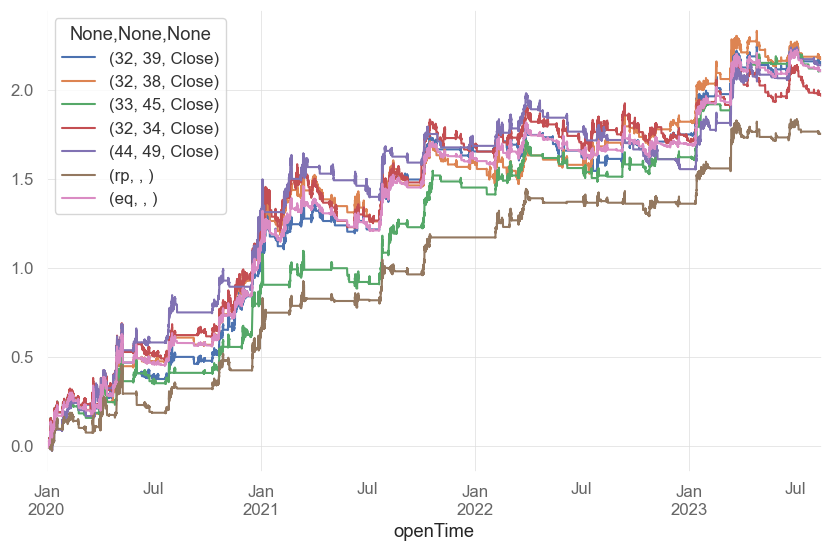

In [249]:
entries_list = []
exits_list = []

for param in idx_best_5_sharpe:

    signal = MyInd.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio = vbt.Portfolio.from_signals(
    price_all['Close'].shift(-1),
    entries_df,
    exits_df,
    freq = '15m', 
    direction = 'longonly',
    sl_stop = 0.03,
    fees = 0.0015,
    init_cash=10000
)

rett = portfolio.returns()

n = 72 * 6
rolling_risk = rett.rolling(n).std()
w_df_ = ((1/rolling_risk).T/(1/rolling_risk).sum(axis = 1)).T

rett['rp'] = (rett * w_df_).sum(axis = 1)
rett['eq'] = rett.iloc[:, :5].mean(axis = 1) 

rett.cumsum().plot()

df_metrics = pd.DataFrame()
for col in rett.columns:
    df_metrics[col] = qs.reports.metrics(rett[col], mode='full', display=False, periods_per_year = 4 * 24 * 365)

df_metrics.head(50)

<Axes: title={'center': 'Cumsum'}, xlabel='openTime'>

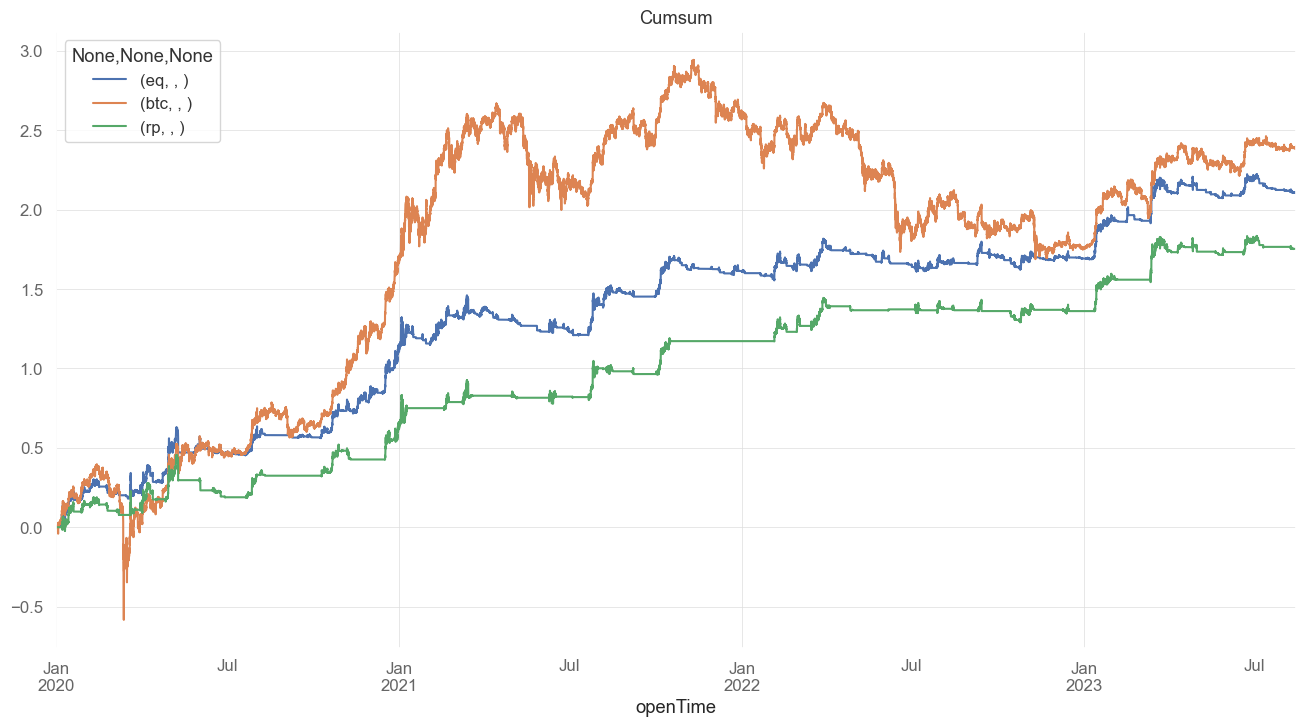

In [252]:
rett['btc'] = df['Close'].pct_change()
fig, ax = plt.subplots(figsize=(16,8))
rett[['eq', 'btc', 'rp']].cumsum().plot(ax=ax, title = 'Cumsum')

In [253]:
qs_metrics = pd.DataFrame()

days = 252
compounded = True

qs_metrics["benchmark"] = qs.reports.metrics(rett['btc'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["eq_in_sample"] = qs.reports.metrics(rett['eq']['2020-01-01':'2022-08-31'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["eq_out_sample"] = qs.reports.metrics(rett['eq']['2022-09-01':'2023-08-15'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["eq_all"] = qs.reports.metrics(rett['eq'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["rp_in_sample"] = qs.reports.metrics(rett['rp']['2020-01-01':'2022-08-31'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["rp_out_sample"] = qs.reports.metrics(rett['rp']['2022-09-01':'2023-08-15'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)
qs_metrics["rp_all"] = qs.reports.metrics(rett['rp'], mode='full', display=False, periods_per_year =4 * 24 * days, compounded = compounded)

In [244]:
day_rett = rett.resample("1D").sum()
print(day_rett)
mean = np.mean(day_rett['eq'])*252
print(mean)
std = np.std(day_rett['eq']) * (252**0.5)
sharpe = round(mean/std, 4)
print(sharpe)

                  32                  33        32    44   rp        eq  \
                  39        38        45        34    49                  
               Close     Close     Close     Close Close                  
openTime                                                                  
2020-01-01  0.000000  0.000000  0.000000  0.000000   0.0  0.0  0.000000   
2020-01-02  0.000000  0.000000  0.000000  0.000000   0.0  0.0  0.000000   
2020-01-03  0.015027  0.015027  0.015027  0.015027   0.0  0.0  0.012022   
2020-01-04  0.006498  0.006498  0.006498  0.006498   0.0  0.0  0.005198   
2020-01-05 -0.000351 -0.000351 -0.000351 -0.000351   0.0  0.0 -0.000281   
...              ...       ...       ...       ...   ...  ...       ...   
2023-08-11 -0.001718 -0.001718  0.000000 -0.001718   0.0  0.0 -0.001031   
2023-08-12  0.000757  0.000757  0.000000  0.000757   0.0  0.0  0.000454   
2023-08-13 -0.003412 -0.003412  0.000000 -0.003412   0.0  0.0 -0.002047   
2023-08-14 -0.005565 -0.0

In [247]:
qs_metrics.head(60)

,benchmark,eq_in_sample,eq_out_sample,eq_all,rp_in_sample,rp_out_sample,rp_all
Start Period,2020-01-01,2020-01-01,2022-09-01,2020-01-01,2020-01-01,2022-09-01,2020-01-01
End Period,2023-08-15,2022-08-31,2023-08-15,2023-08-15,2022-08-31,2023-08-15,2023-08-15
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,1.0,0.48,0.5,0.48,0.26,0.31,0.27
Cumulative Return,3.1,3.73,0.48,6.0,2.39,0.43,3.84
CAGR﹪,0.31,0.5,0.33,0.45,0.37,0.29,0.35
Sharpe,0.74,1.53,1.37,1.49,1.39,1.32,1.37
Prob. Sharpe Ratio,0.96,1.0,0.95,1.0,1.0,0.94,1.0
Smart Sharpe,0.74,1.53,1.29,1.47,1.38,1.26,1.35
Sortino,1.06,2.14,1.98,2.09,1.94,1.91,1.93


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-08-15   2023-08-15
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       48.0%

Total Return               241.44%      214.45%
CAGR﹪                     26.44%       24.47%

Sharpe                     0.91         1.79
Prob. Sharpe Ratio         95.79%       99.96%
Smart Sharpe               0.9          1.77
Sortino                    1.29         2.52
Smart Sortino              1.28         2.5
Sortino/√2                 0.91         1.78
Smart Sortino/√2           0.9          1.77
Omega                      1.05         1.05

Max Drawdown               -77.27%      -21.23%
Longest DD Days            643          292
Volatility (ann.)          73.71%       33.16%
R^2                        0.0          0.0
Information Ratio          -0.0         -0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-03-13,2021-07-10,2021-07-26,135,-21.226412,-21.093065
2,2022-03-28,2022-10-24,2023-01-13,292,-19.844525,-18.670900
3,2020-05-08,2020-07-20,2020-10-21,167,-16.805945,-16.520359
4,2021-01-03,2021-01-06,2021-02-19,48,-16.241564,-15.837268
5,2023-04-26,2023-05-28,2023-08-15,111,-14.203170,-14.014382


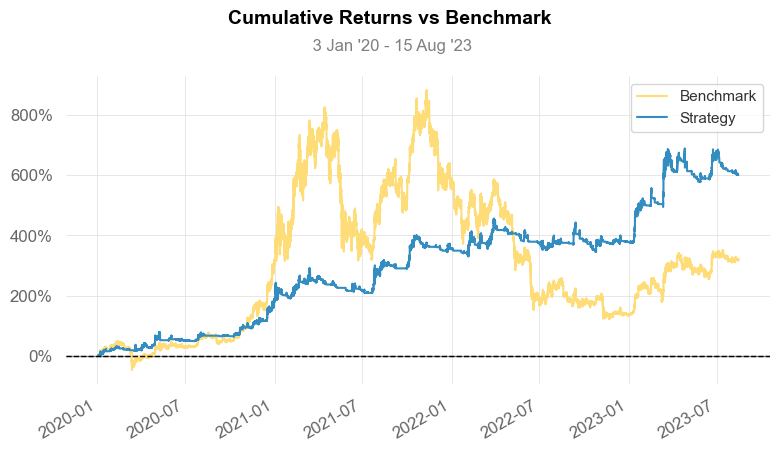

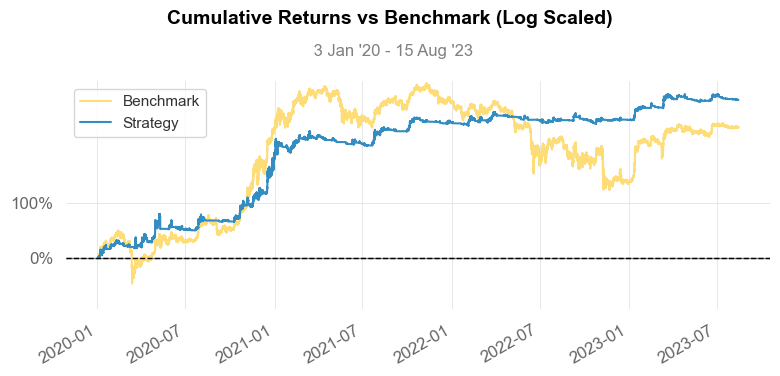

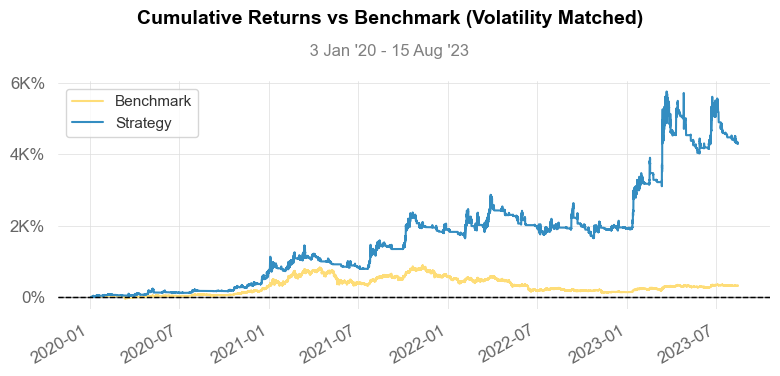

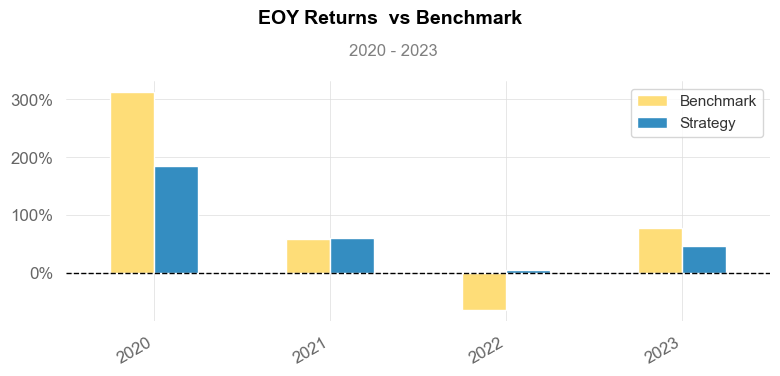

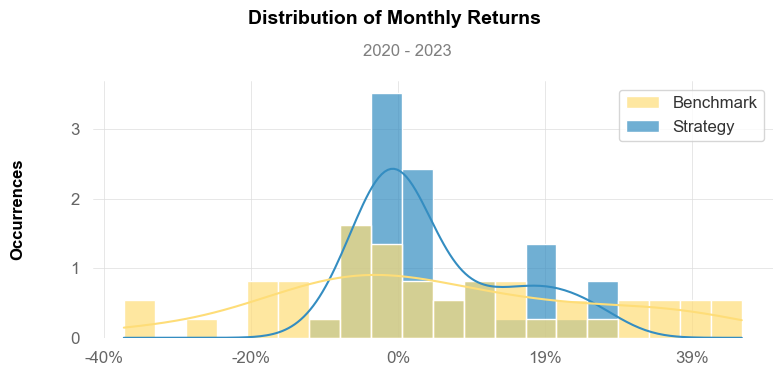

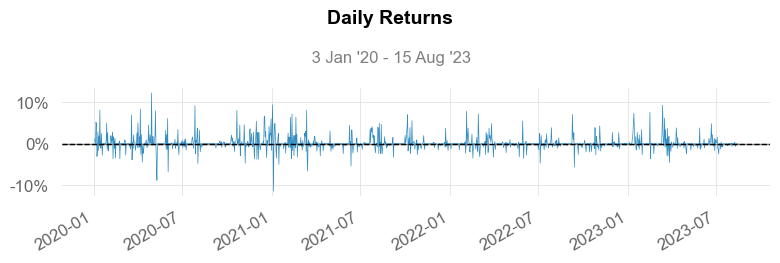

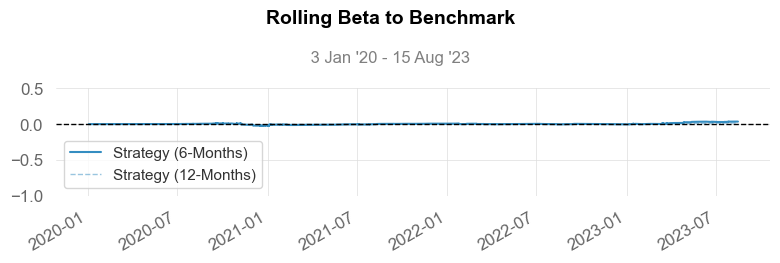

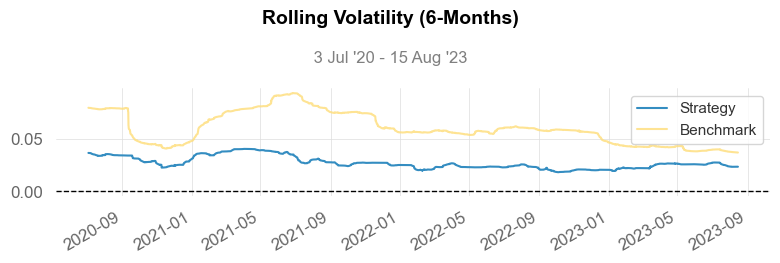

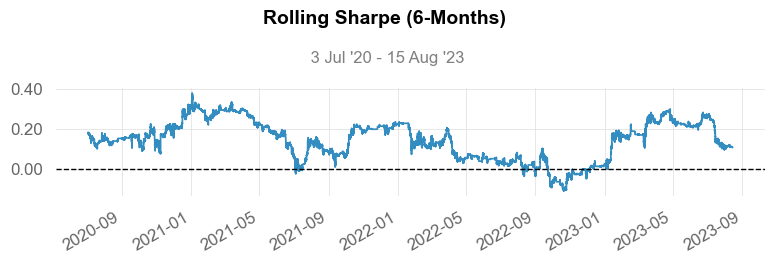

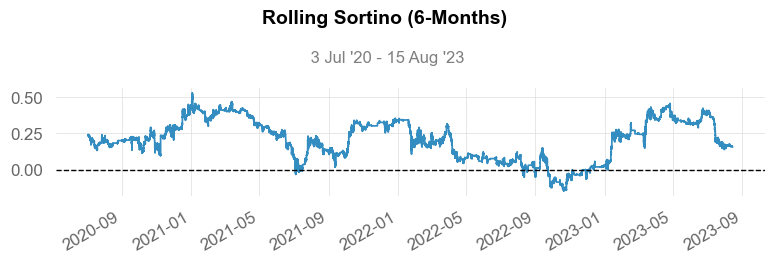

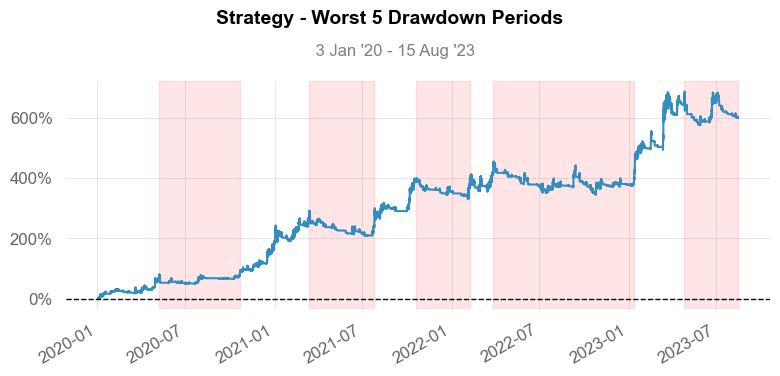

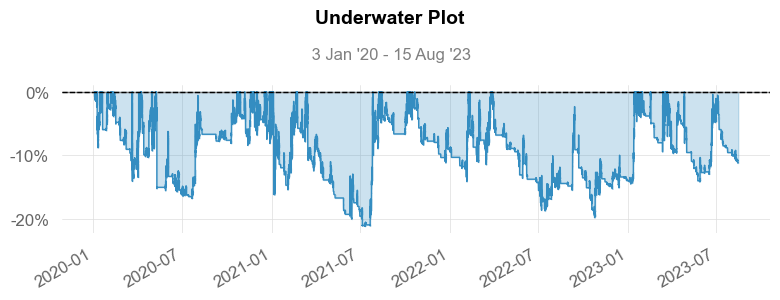

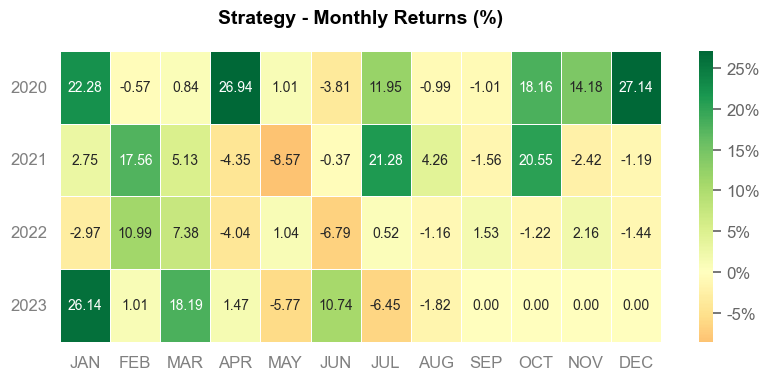

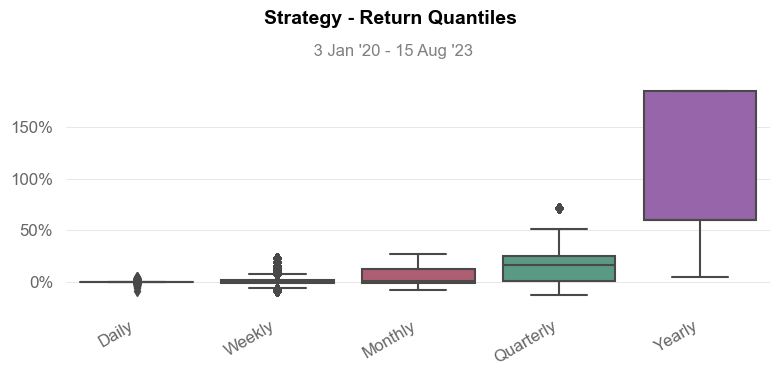

In [248]:
qs.reports.full(rett['eq'], benchmark = rett['btc'], periods_per_year= 24 * 4 *365, compounded=False, active_returns=False)